## IMPORTS

In [108]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns   # plotting heatmap
torch.manual_seed(1)
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, LSTM, Bidirectional
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.regularizers import l2
from time import time
from sklearn.model_selection import train_test_split
import pickle

## IMPORT DATA

In [3]:
df_train = pd.read_csv("datasets/ptbdb_train.csv",header=None)
df_test = pd.read_csv("datasets/ptbdb_test.csv",header=None)

## LSTM

In [37]:
X_train, y_train = [], [] 
X_train = df_train.iloc[:,:-1].values
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
y_train = df_train.iloc[:,-1].values

def balance_dataset(X_train, y_train):
    # Find indices of each class
    indices_class_0 = np.where(y_train == 0)[0]
    indices_class_1 = np.where(y_train == 1)[0]
    
    num_class_0 = len(indices_class_0)
    num_class_1 = len(indices_class_1)
    
    minority_class_size = min(num_class_0, num_class_1)
    
    # Randomly sample indices from both classes to match minority class size
    sampled_indices_class_0 = np.random.choice(indices_class_0, size=minority_class_size, replace=False)
    sampled_indices_class_1 = np.random.choice(indices_class_1, size=minority_class_size, replace=False)
    
    # Combine sampled indices
    sampled_indices = np.concatenate((sampled_indices_class_0, sampled_indices_class_1))
    
    # Shuffle sampled indices
    np.random.shuffle(sampled_indices)
    
    # Create balanced dataset
    X_balanced = X_train[sampled_indices]
    y_balanced = y_train[sampled_indices]
    
    return X_balanced, y_balanced

# Assuming X_train and y_train are your training data
X_train, y_train = balance_dataset(X_train, y_train)



X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, shuffle=True)

X_test, y_test = [], []
X_test = df_test.iloc[:,:-1].values
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
y_test = df_test.iloc[:,-1].values


In [65]:
M_TRAIN = X_train.shape[0]
M_TEST = X_test.shape[0]
N = X_train.shape[2]
T = X_train.shape[1]

BATCH = 64
EPOCH = 50
LR = 1e-3  # Adjusted learning rate

1 187


In [101]:
model = Sequential()
model.add(LSTM(50, input_shape=(T, N)))
model.add(Dense(1, activation='sigmoid'))

# Compile the model with Adam optimizer
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)
# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)

start = time()
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
'''History = model.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH, validation_data = (X_val, y_val),callbacks=[early_stopping, reduce_lr])

model.save('models/lstm_model.keras')
with open('models/lstm_history.pkl', 'wb') as file:
    pickle.dump(History.history, file)'''


with open('models/lstm_history.pkl', 'rb') as file:
    History = pickle.load(file)
model = keras.models.load_model('models/lstm_model.keras')

print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)


/home/ilboglions/anaconda3/envs/MLHC/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_74 (LSTM)                  │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

None
-----------------------------------------------------------------
Training was completed in 0.05 secs
-----------------------------------------------------------------


-----------------------------------------------------------------
train accuracy = 80.1345%
test accuracy = 75.9533%
test error = 700 out of 2911 examples


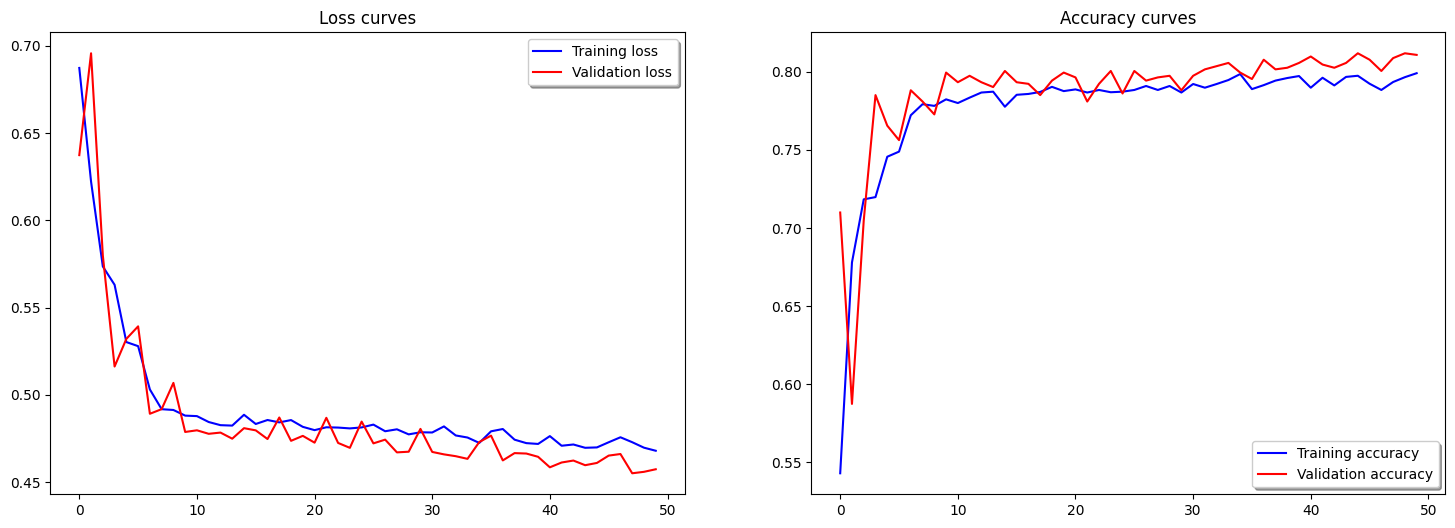

In [102]:
# Evaluate the model:
train_loss, train_acc = model.evaluate(X_train, y_train,
                                       batch_size=M_TRAIN, verbose=0)
test_loss, test_acc = model.evaluate(X_test[:M_TEST], y_test[:M_TEST],
                                     batch_size=M_TEST, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History['loss'], color='b', label='Training loss')
axs[0].plot(History['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

In [103]:
bidirectional_model = Sequential()
bidirectional_model.add(Bidirectional(LSTM(50), input_shape=(T, N)))
bidirectional_model.add(Dense(1, activation='sigmoid'))  # Output layer with sigmoid activation for binary classification

# Compile the model
bidirectional_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)

# Train the model with callbacks
'''History = bidirectional_model.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH, validation_data=[X_val, y_val], callbacks=[early_stopping, reduce_lr])
bidirectional_model.save('models/bidirectional_model.keras')
with open('models/bidir_history.pkl', 'wb') as file:
    pickle.dump(History.history, file)'''

with open('models/bidir_history.pkl', 'rb') as file:
    History = pickle.load(file)

bidirectional_model = keras.models.load_model('models/bidirectional_model.keras')


print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)

-----------------------------------------------------------------
Training was completed in 35.31 secs
-----------------------------------------------------------------


/home/ilboglions/anaconda3/envs/MLHC/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


-----------------------------------------------------------------
train accuracy = 86.1141%
test accuracy = 84.404%
test error = 454 out of 2911 examples


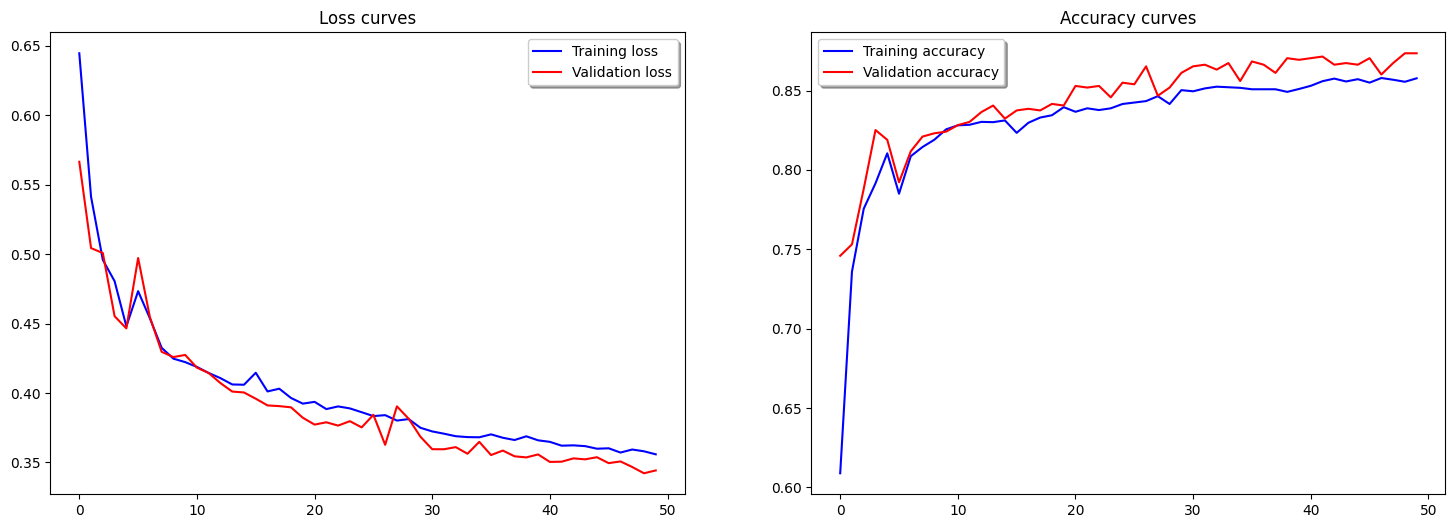

In [104]:
# Evaluate the model:
train_loss, train_acc =  bidirectional_model.evaluate(X_train, y_train,
                                       batch_size=M_TRAIN, verbose=0)
test_loss, test_acc = bidirectional_model.evaluate(X_test[:M_TEST], y_test[:M_TEST],
                                     batch_size=M_TEST, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History['loss'], color='b', label='Training loss')
axs[0].plot(History['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

## ATTENTION AND TRANSFORMERS

In [105]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0):
    inputs = tf.keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    return tf.keras.Model(inputs, outputs)

# Define your parameters
input_shape = (187, 1)
head_size = 256
num_heads = 4
ff_dim = 4
num_transformer_blocks = 4
mlp_units = [128]
dropout = 0.25
mlp_dropout = 0.25

# Build the model
model = build_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout, mlp_dropout)

# Compile the model
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train the model with EarlyStopping callback
'''model.fit(X_train, y_train, 
          batch_size=64, 
          epochs=100, 
          validation_data=(X_val, y_val), 
          callbacks=[early_stopping])
model.save('models/transformers_model.keras')'''

model = keras.models.load_model('models/transformers_model.keras')


test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')


91/91 ━━━━━━━━━━━━━━━━━━━━ 27s 298ms/step - accuracy: 0.9275 - loss: 0.1918
test accuracy = 92.7516%
test error = 211 out of 2911 examples


In [106]:
indices_class_0 = np.where(y_train == 0)[0]
indices_class_1 = np.where(y_train == 1)[0]
    
n_samples = 3  


sampled_indices_class_1 = np.random.choice(indices_class_1, size=n_samples, replace=False)
sampled_indices_class_0 = np.random.choice(indices_class_0, size =n_samples,replace = False)
#sampled_indices_class_0 = np.random.choice(indices_class_0, size=n_samples replace=False)
X_negative = X_train[sampled_indices_class_0]
X_positive = X_train[sampled_indices_class_1]



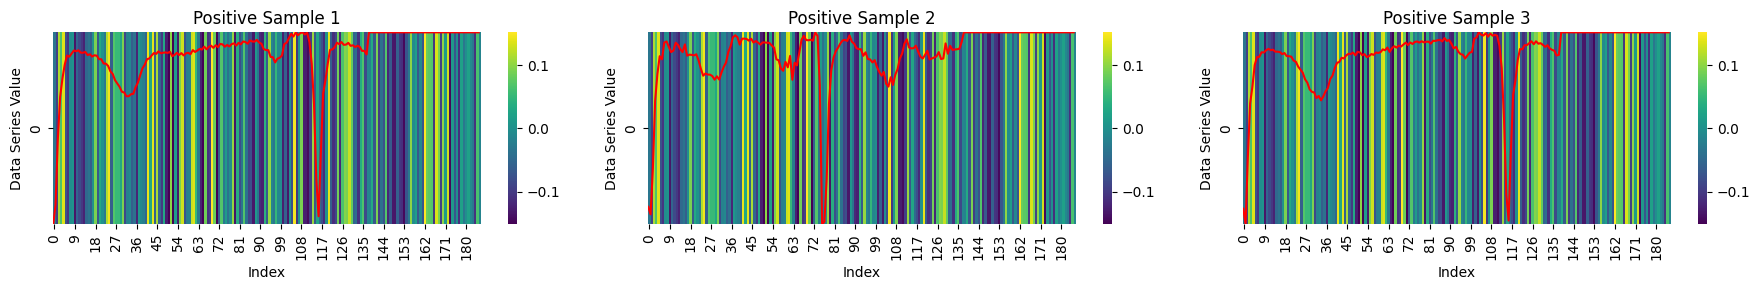

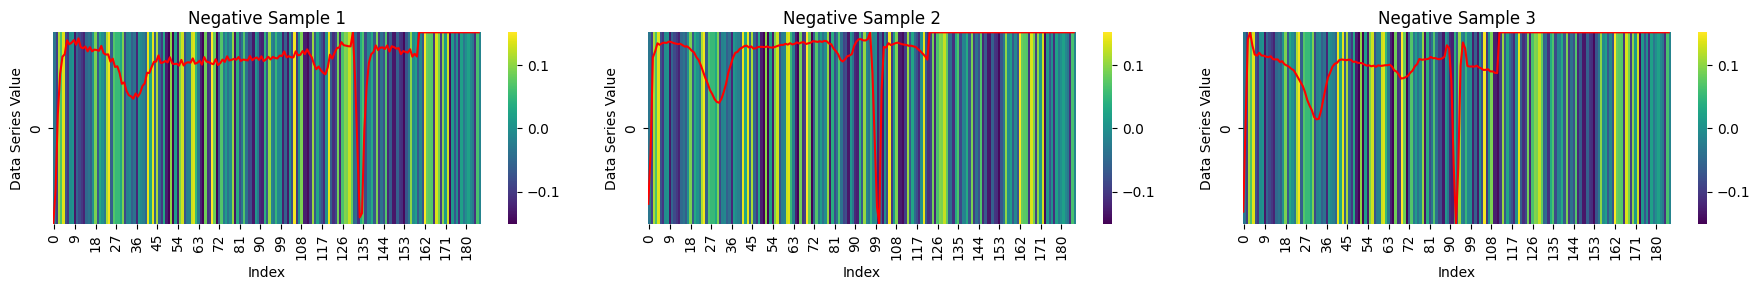

In [107]:
input_layer_weights = model.layers[2].get_weights()[0][0,0,:]

fig, axs = plt.subplots(1, n_samples, figsize=(18, 3))  # Create subplots with 1 row and 6 columns

for i, ax in enumerate(axs):
    sns.heatmap(np.array([input_layer_weights[:187]]), cmap='viridis', ax=ax)
    ax.plot(X_positive[i], color='red')
    
    # Set labels
    ax.set_xlabel('Index')
    ax.set_ylabel('Data Series Value')
    ax.set_title(f'Positive Sample {i+1}')  # Set title for each subplot

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

fig, axs = plt.subplots(1, n_samples, figsize=(18, 3))  # Create subplots with 1 row and 6 columns

for i, ax in enumerate(axs):
    sns.heatmap(np.array([input_layer_weights[:187]]), cmap='viridis', ax=ax)
    ax.plot(X_negative[i], color='red')
    
    # Set labels
    ax.set_xlabel('Index')
    ax.set_ylabel('Data Series Value')
    ax.set_title(f'Negative Sample {i+1}')  # Set title for each subplot

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()